# 6. Implementación de algoritmos de Machine Learning

---

<p style="text-align: justify;">A continuación, se generan tres modelos con la implementación de diversos algoritmos de Machine Learning, buscando obtener el mejor resultado posible en cuanto a la predicción de la satisfacción o insatisfacción de un usuario antes de recibir una respuesta por parte de una compañía de servicios financieros sobre una queja presentada por el mismo, utilizando las variables seleccionadas.</p>

<p style="text-align: justify;">Para este modelo, se utilizarán además métodos de optimización de parámetros y validación cruzada, buscando generar un modelo funcional.</p>

<p style="text-align: justify;"><b>Nota: Los métricos de evaluación pueden presentar variaciones muy ligeras a las que se presentan en las descripciones, esto debido a que el muestreo utilizado para los conjuntos de entrenamiento y prueba se genera de manera aleatoria. No obstante, se ha validado que las variaciones son mínimas después de ciertas iteraciones.</p>

Primero, se importan las librerías requeridas y el conjunto de datos previamente procesado.

In [1]:
# Importación de datos y gestión de rutas
import sys
sys.path.append('..') # Folder principal del projecto
from config import MODEL_DATA_PATH

# Computación científica y manejo de datos
import pandas as pd
import numpy as np
from scipy.stats import randint

#Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

#Machine learning y evaluación del modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb


#Filtrar warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importar conjunto de datos procesado
try:
    df = pd.read_csv(MODEL_DATA_PATH, low_memory=False)
except:
    raise FileNotFoundError('No se encontró el archivo, favor de ejecutar el Notebook "3_data_wrangling.ipynb"')

# Observar primeras filas del DataFrame
df.head(5)

,month,quarter,product,issue,company_response_to_consumer,company,consumer_disputed?,submitted_via,timely_response
0,2,1,Mortgage,"Loan modification,collection,foreclosure",Closed with explanation,Ocwen,Yes,Web,Yes
1,4,2,Mortgage,"Loan modification,collection,foreclosure",Closed with explanation,Ocwen,Yes,Web,Yes
2,7,3,Mortgage,"Loan servicing, payments, escrow account",Closed with explanation,Nationstar Mortgage,Yes,Web,Yes
3,7,3,Mortgage,"Loan modification,collection,foreclosure",Closed with explanation,JPMorgan Chase & Co.,Yes,Referral,Yes
4,4,2,Mortgage,"Loan modification,collection,foreclosure",Closed without relief,Bank of America,Yes,Referral,Yes


## 6.1 Preparación del conjunto de datos

### 6.1.1 OneHotEncoding

<p style="text-align: justify;">A continuación, se lleva a cabo el proceso de OneHotEncoding, el cual consiste en convertir todas las variables categóricas en variables numéricas con valores binarios (0,1); esto con la finalidad de que sea posible el que formen parte de un algoritmo de aprendizaje automático.</p>

In [3]:
#Separar la variable dependiente y las variables independientes.
X = df.drop('consumer_disputed?', axis = 1)
y = df['consumer_disputed?']

In [4]:
#Observar las variables independientes.
X.columns

Index(['month', 'quarter', 'product', 'issue', 'company_response_to_consumer',
       'company', 'submitted_via', 'timely_response'],
      dtype='object')

In [5]:
#Crear una lista con las variables independientes.
categories = ['month', 'quarter', 'product', 'issue', 'company_response_to_consumer',
                              'company','submitted_via', 'timely_response']

In [6]:
#Preparar el OneHotEncoding
preprocessor = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), categories)], remainder = 'passthrough')

In [7]:
#Procesar nuestros datos con el OneHotEncoding.
X_encoded = preprocessor.fit_transform(X)

## 6.2 Random Forest Classifier con Tuning de Hiperparámetros

<p style="text-align: justify;">El primer algoritmo que se implementará es un RandomForest Classifier, el cual es un algoritmo muy popular para casos de aprendizaje automático para tareas de regresión y clasificación, y se basa en la combinación de múltiples árboles de decisión para realizar predicciones. Además, se buscarán optimizar ciertos hiperparámetros a través de un RandomizedSearchCV, herramienta que se encargará de devolvernos los mejores resultados posibles.</p>

In [8]:
#A continuación se preparan los conjuntos de prueba y entrenamiento.
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

In [9]:
#Se crea un diccionario con los hiperparámetros que se buscan optimizar.
parametros = {
    'n_estimators': randint(100, 1000),  # Numero de árboles.
    'max_depth': randint(1, 7),  # Profundidad máxima de cada árbol.
    'min_samples_split': randint(2, 20),  # Número mínimo de muestras requeridas para poder partir un nodo interno.
    'min_samples_leaf': randint(1, 10),  # Número mínimo de muestras requeridas dentro de cada "hoja".
    'max_features': ['auto', 'sqrt'],  # Número de parámetros a considerar al buscar la mejor partición.
    'bootstrap': [True, False]  # ¿Se entrenarán las muestras en sets agrupados?
}

In [10]:
#Inicializar el algoritmo y hacer el fit dentro de los conjuntos de entrenamiento.
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

#Inicializar el tuning de hiperparámetros, implementándolo dentro del algoritmo.
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=parametros, n_iter=10, cv=5)
random_search.fit(X_train, y_train)

#Predicción en Train
y_train_pred = random_search.predict(X_train)

#Predicción en Test
y_test_pred = random_search.predict(X_test)

### 6.2.1 Accuracy

In [11]:
#Obtener el accuracy del modelo.
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", f'{round(np.round(random_search.best_score_,2) * 100,2)}%')

Best Parameters:  {'bootstrap': False, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 787}
Best Score:  58.0%


<p style="text-align: justify;">Se puede observar que el accuracy es apenas cercano al 60%, es decir, en 6 de cada 10 ocasiones el modelo predice de manera correcta si hubo satisfacción con la resolución de una queja o si hubo disputa por parte del cliente. Esto por supuesto no es un resultado óptimo, ya que ronda la aleatoriedad y no brinda confiabilidad a la audiencia.</p>

<p style="text-align: justify;">Cabe destacar que se ha iterado con diversas combinaciones de variables previamente, y este ha sido el resultado más alto para el modelo utilizando un algoritmo de Random Forest.</p>

### 6.1.2 Matriz de Confusión

In [12]:
# Crear Series para los valores true, los cuales serán utilizados en la matriz de confusión.
y_train_true = y_train
y_test_true = y_test

#Generar los valores de la matriz de confusión.
matriz_confusion = confusion_matrix(y_test_true, y_test_pred)
print(matriz_confusion)

[[ 621  842]
 [ 403 1134]]


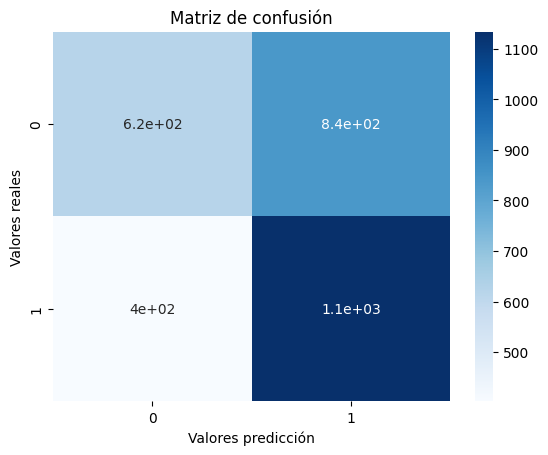

In [13]:
# Crear la visualización de la matriz de confusión.
sns.heatmap(matriz_confusion, annot=True, cmap='Blues')

plt.xlabel('Valores predicción')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')

plt.show()

<p style="text-align: justify;">Se puede observar un mejor performance al momento de predecir valores positivos, lo cual es bastante interesante, ya que logra predecir de mejor manera el valor con menor frecuencia o más desbalanceado dentro del conjunto de datos. Esto podría ser beneficioso, ya que se le podría encontrar un enfoque especial a este algoritmo para predecir valores positivos o medir la probabilidad de que un valor sea positivo.</p>

### 6.1.3 Precision Score

In [14]:
#Obtener el Precision Score.
y_pred = random_search.predict(X_test)
precision = precision_score(y_test, y_pred, pos_label='Yes')

print(f'Precisión: {round(np.round(precision,2)*100,2)}%')

Precisión: 57.0%


La precisión de este modelo valida lo que se argumentó previamente al obtener el accuracy del modelo.

### 6.1.4 Recall Score

In [15]:
#Obtener el Recall Score.
y_pred = random_search.predict(X_test)
recall = recall_score(y_test, y_pred, pos_label='Yes')

print(f'Recall Score: {np.round(recall,2)*100}%')

Recall Score: 74.0%


<p style="text-align: justify;">El Recall Score, al estar por encima del 70%, valida lo que se ha observado en la matríz de confusión, y es que el modelo podría ser utilizado exclusivamente para medir la probabilidad o apoyar a la decisión cuando se tenga la hipótesis de que un valor va a ser positivo, es decir, que exista una disputa por parte del cliente. Como se mencionó de igual manera anteriormente, es interesante este comportamiento y podría ser bastante útil, y que la variable se encuentra altamente desbalanceada, inclinada hacia los casos que NO generan disputa en una proporción 80/20.</p>

### 6.1.5 F1 Score

In [16]:
#Obtener el F1 Score.
f1 = f1_score(y_test, y_pred, pos_label='Yes')

print(f'F1 Score:{np.round(f1,2)*100}%')

F1 Score:65.0%


<p style="text-align: justify;">El F1 Score en este caso muestra que el modelo tiene actualmente un rendimiento aceptable, pero con un márgen de mejora. No obstante, como se ha mencionado con anterioridad, iterando con distintas variables no se ha podido obtener una métrica superior al 70% con un modelo que utilice un algoritmo de Random Forest.</p>

### 6.1.6 Reporte General

In [17]:
print(classification_report(y_pred = y_pred, y_true = y_test))

              precision    recall  f1-score   support

          No       0.61      0.42      0.50      1463
         Yes       0.57      0.74      0.65      1537

    accuracy                           0.58      3000
   macro avg       0.59      0.58      0.57      3000
weighted avg       0.59      0.58      0.57      3000



## 6.2 LightGBM con Tuning de Hiperparámetros

<p style="text-align: justify;">A continuación se implementa al modelo el algoritmo de Light Gradient Boosting Machine, una implementación de gradient boosting framework que itera sobre varios modelos débiles para poder llegar gradualmente a una optimización bastante precisa. Además, de igual manera se incluirá un modelo de tuning de hiperparámetros, utilizando de igual manera el método de validación cruzada RandomizedSearchCV.</p>

In [18]:
#A continuación se preparan los conjuntos de prueba y entrenamiento.
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [19]:
# Definir los parámetros para la implementación de RandomizedSearchCV para la optimización del algoritmo.
parametros = {
    'boosting_type': ['gbdt', 'dart', 'goss'], #Determinar qué algoritmo se adapta mejor al modelo.
    'num_leaves': randint(10, 100),            #Máximo número de hojas en cada árbol.
    'learning_rate': [0.01, 0.1, 0.2],         #Tamaño de cada iteración.
    'feature_fraction': [0.6, 0.7, 0.8],       #Fracción de características que se toman para cada árbol.
    'bagging_fraction': [0.6, 0.7, 0.8],       #Fracción de las muestras que se toman para cada árbol.
    'bagging_freq': randint(1, 10),            # Cada cuántas iteraciones se realiza el bagging.
    'lambda': [0.01, 0.1, 1.0],                #Regularización L2 (eliminar variables no relevantes) en los pesos.
    'alpha': [0.01, 0.1, 1.0],                 #Regularización L2 (remover impacto de variables no relevantes) en los pesos.
    'min_child_samples': randint(5, 50),       #Mínimo de valores en cada muestra (hoja).
    'max_depth': randint(3, 10),               #Profundidad máxima de cada árbol.
    'objective': ['binary'],                   #Función de pérdida que se busca optimizar (se busca una clasificación binaria).
    'metric': ['binary_logloss']               #Métrica de evaluación utilizada en el entrenamiento.
}

In [20]:
#Inicializar el algoritmo.
light_gbm = lgb.LGBMClassifier()

#RandomizedSearch CV (Cross-Validation) con un total de 5 folds.
random_search_gbm = RandomizedSearchCV(estimator=light_gbm, param_distributions=parametros, n_iter=10, cv=5, random_state = 42)
random_search_gbm.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.0. Current value: lambda_l2=1.0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.0. Current value: lambda_l2=1.0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Number of positive: 3191, number of nega

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(),
                   param_distributions={'alpha': [0.01, 0.1, 1.0],
                                        'bagging_fraction': [0.6, 0.7, 0.8],
                                        'bagging_freq': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002647D5B0740>,
                                        'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'feature_fraction': [0.6, 0.7, 0.8],
                                        'lambda': [0.01, 0.1, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002647F6F7470>,
                                        'metric': ['binary_logloss'],
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002647F66EA80>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002647F6E2CF0>,
                                        'objective': ['binary']},
                   random_state=42)

In [21]:
#Hacer el fit del modelo en el conjunto de datos de entrenamiento (Train).
random_search_gbm.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.0. Current value: lambda_l2=1.0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.0. Current value: lambda_l2=1.0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Number of positive: 3191, number of nega

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(),
                   param_distributions={'alpha': [0.01, 0.1, 1.0],
                                        'bagging_fraction': [0.6, 0.7, 0.8],
                                        'bagging_freq': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002647D5B0740>,
                                        'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'feature_fraction': [0.6, 0.7, 0.8],
                                        'lambda': [0.01, 0.1, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002647F6F7470>,
                                        'metric': ['binary_logloss'],
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002647F66EA80>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002647F6E2CF0>,
                                        'objective': ['binary']},
                   random_state=42)

In [22]:
#Extraer el modelo que haya arrojado los mejores resultados, con sus respectivos parámetros.
best_model = random_search_gbm.best_estimator_
best_params = random_search_gbm.best_params_

In [23]:
#Generar las predicciones.
predicciones = best_model.predict(X_test)
predicciones

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.0. Current value: lambda_l2=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


array(['Yes', 'Yes', 'Yes', ..., 'No', 'Yes', 'Yes'], dtype=object)

In [24]:
#Predicción en Train.
y_train_pred = best_model.predict(X_train)
#Predicción en Test.
y_test_pred = best_model.predict(X_test);

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.0. Current value: lambda_l2=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.0. Current value: lambda_l2=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


### 6.2.1 Accuracy

In [25]:
print("Best Parameters: ", random_search_gbm.best_params_)
print("Best Score: ", round(np.round(random_search_gbm.best_score_,2) * 100,2))

Best Parameters:  {'alpha': 0.1, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'lambda': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'metric': 'binary_logloss', 'min_child_samples': 40, 'num_leaves': 59, 'objective': 'binary'}
Best Score:  59.0


<p style="text-align: justify;">El accuracy del modelo con la implementación de un LightGBM optimizado es bastante similar al obtenido en el modelo anterior, por lo que se tiene la misma conclusión, un modelo moderado con un nivel de aciertos regular acercandose a ser aceptable.</p>

### 6.2.2 Matriz de confusión

In [26]:
# Crear Series para los valores true, los cuales serán utilizados en la matriz de confusión.
y_train_true = y_train
y_test_true = y_test

#Generar los valores de la matriz de confusión.
matriz_confusion = confusion_matrix(y_test_true, y_test_pred)
print(matriz_confusion)

[[460 528]
 [322 690]]


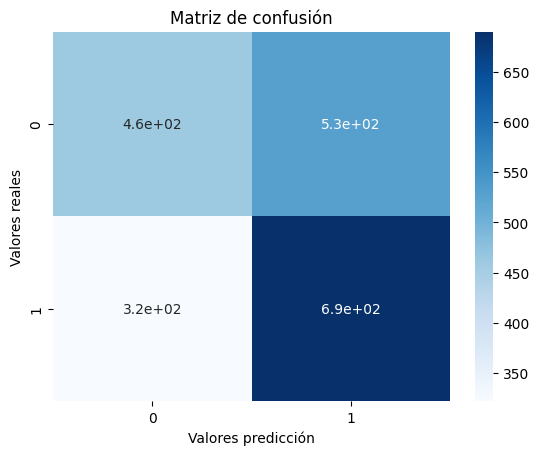

In [27]:
# Crear la visualización de la matriz de confusión
sns.heatmap(matriz_confusion, annot=True, cmap='Blues')

plt.xlabel('Valores predicción')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')

plt.show()

<p style="text-align: justify;">La matríz de confusión muestra en este caso un mejor balance entre verdaderos positivos y verdaderos negativos, y acierta en un mayor número de veces en ambos casos, por lo que se podría concluir por este lado que el modelo es aceptable.</p>

### 6.2.3 Precision Score

In [28]:
#Obtener el Precision Score.
y_pred = best_model.predict(X_test)
precision = precision_score(y_test, y_pred, pos_label='Yes')

print(f'Precisión: {round(np.round(precision,2)*100,2)}%')

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.0. Current value: lambda_l2=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Precisión: 57.0%


El precision score en este caso de igual manera no deja mucho que decir, simplemente valida lo observado en el accuracy.

### 6.2.4 Recall Score

In [29]:
#Obtener el Recall Score.
y_pred = best_model.predict(X_test)
recall = recall_score(y_test, y_pred, pos_label='Yes')

print(f'Recall Score: {np.round(recall,2)*100}%')

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.0. Current value: lambda_l2=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Recall Score: 68.0%


<p style="text-align: justify;">El Recall Score en este caso se acerca mucho al 75%, lo cual muestra que el modelo podría fungir de igual manera, o incluso mejor, como un modelo para reforzar la teoría o validar casos potenciales con valores verdaderos positivos.</p>

### 6.2.5 F1 Score

In [30]:
#Obtener el F1 Score.
f1 = f1_score(y_test, y_pred, pos_label='Yes')

print(f'F1 Score:{np.round(f1,2)*100}%')

F1 Score:62.0%


<p style="text-align: justify;">El F1 Score obtenido en este caso es bastante similar al modelo anterior, y de igual manera categoriza a este modelo como aceptable con potencial de mejora. Sin embargo, su punto fuerte como ya se mencionó, se encuentra en su potencial para validación de verdaderos positivos.</p>

### 6.2.6 Reporte General

In [31]:
print(classification_report(y_pred = y_pred, y_true = y_test))

              precision    recall  f1-score   support

          No       0.59      0.47      0.52       988
         Yes       0.57      0.68      0.62      1012

    accuracy                           0.57      2000
   macro avg       0.58      0.57      0.57      2000
weighted avg       0.58      0.57      0.57      2000



## 6.3 LogisticRegression con Tuning de Hiperparámetros

In [32]:
#Crear los conjuntos de prueba y entrenamiento.
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [33]:
#Inicializar el algoritmo.
logistic_reg = LogisticRegression()

In [34]:
# Definir los hiperparámetros a optimizar.
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'penalty': ['l1', 'l2'],  # Tipo de regularización ('l1' = Lasso, 'l2' = Ridge)
    'solver': ['liblinear', 'saga']}  # Algoritmo de optimización

In [35]:
#Definir el método de Cross Validation a utilizar para este algoritmo.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [36]:
#Definir el método de Cross Validation con optimización de hiperparámetros a utilizar.
grid_search = GridSearchCV(logistic_reg, param_grid, scoring='accuracy', cv=cv)

In [37]:
#Hacer el fit para el conjunto de entrenamiento.
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [38]:
# Obtener los mejores hiperparámetros con GridSearchCV.
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Hacer las predicciones.
y_pred = best_model.predict(X_test)

#### Métricas y evaluación

### 6.3.1 Accuracy

In [39]:
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", round(np.round(grid_search.best_score_,2) * 100,2))

Best Parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score:  58.0


<p style="text-align: justify;">El accuracy del modelo con un algoritmo de LogisticRegression es de igual manera muy similar al que se obtuvo en los dos modelos anteriores, lo cuál muestra un patrón bastante interesante, y puede ser causa de la naturaleza de las variables y una baja correlación entre las mismas.</p>

### 6.3.2 Matriz de confusión

In [40]:
# Crear Series para los valores true, los cuales serán utilizados en la matriz de confusión.
y_train_true = y_train
y_test_true = y_test

#Generar los valores de la matriz de confusión.
matriz_confusion = confusion_matrix(y_test_true, y_test_pred)
print(matriz_confusion)

[[460 528]
 [322 690]]


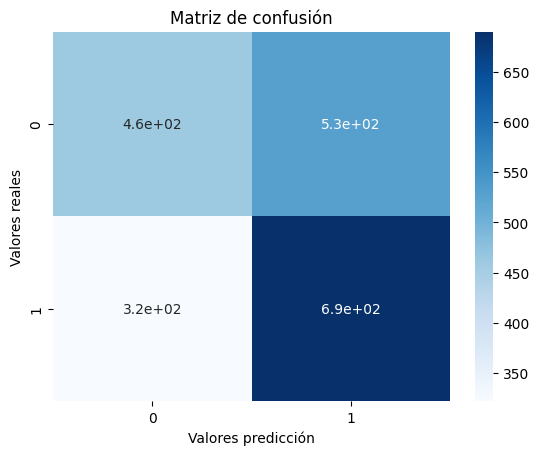

In [41]:
# Crear la visualización de la matriz de confusión
sns.heatmap(matriz_confusion, annot=True, cmap='Blues')

plt.xlabel('Valores predicción')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')

plt.show()

<p style="text-align: justify;">Una curiosidad encontrada en este punto es el cómo con ambas metodologías, empleando tanto el algoritmo de LightGBM como una Logistic Regression, ya sea con un método de optimización de hiper parámetros de RandomizedSearchCV o GridSearch, se han localizado los mismos best parameters. Tanto para el accuracy como para los valores de la matriz de confusión, muestran resultados idénticos.</p>

### 6.3.3 Precision Score

In [42]:
#Obtener el Precision Score.
y_pred = best_model.predict(X_test)
precision = precision_score(y_test, y_pred, pos_label='Yes')

print(f'Precisión: {round(np.round(precision,2)*100,2)}%')

Precisión: 57.0%


En este caso, el Precision Score mejoró muy ligeramente con este algoritmo. Sin embargo, la diferencia no es significativa.

### 6.3.4 Recall Score

In [43]:
#Obtener el Recall Score.
y_pred = best_model.predict(X_test)
recall = recall_score(y_test, y_pred, pos_label='Yes')

print(f'Recall Score: {np.round(recall,2)*100}%')

Recall Score: 68.0%


<p style="text-align: justify;">El Recall Score es más bajo que el obtenido con LightGBM, por lo que no es viable utilizar este algoritmo para la finalidad antes planteada (buscar verdaderos positivos).</p>

### 6.3.5 F1 Score

In [44]:
#Obtener el F1 Score.
f1 = f1_score(y_test, y_pred, pos_label='Yes')

print(f'F1 Score:{np.round(f1,2)*100}%')

F1 Score:62.0%


El F1 Score de igual manera disminuye, más sin embargo es muy similar a la que se obtuvo con los algoritmos anteriores.

### 6.3.6 Reporte General

In [45]:
print(classification_report(y_pred = y_pred, y_true = y_test))

              precision    recall  f1-score   support

          No       0.59      0.47      0.52       988
         Yes       0.57      0.68      0.62      1012

    accuracy                           0.58      2000
   macro avg       0.58      0.58      0.57      2000
weighted avg       0.58      0.58      0.57      2000

